In [137]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [138]:
mnist = input_data.read_data_sets("MNIST_data/", one_hot = True)
x_train = mnist.train.images
y_train = mnist.train.labels
x_test = mnist.test.images
y_test = mnist.test.labels
batch_size = 256
g_dim = 100

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [139]:
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 2, 2, 1], padding = 'SAME')
def deconv2d(x, W, output_shape):
    return tf.nn.conv2d_transpose(x, W, output_shape, strides = [1, 2, 2, 1], padding = 'SAME')


In [140]:
class layer:
    def __init__(self, in_size, out_size):
        self.W = tf.Variable(tf.random_normal([in_size, out_size], mean=0.0, stddev=0.1))
        self.b = tf.Variable(tf.random_normal([1, out_size], mean=0.0, stddev=0.1))
    def output(self, inputs, activation_function=None):
        if activation_function == None:
            return tf.matmul(inputs, self.W) + self.b
        else :
            return activation_function(tf.matmul(inputs, self.W) + self.b)

def weight_variable(shape):
    initial = tf.random_normal(shape, mean=0.0, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.random_normal(shape, mean=0.0, stddev=0.1)
    return tf.Variable(initial)

In [141]:
layer_e = layer(4*4*64, g_dim)
layer_d = layer(g_dim, 4*4*64)

encoder_var = {
    "W_e_conv1" : weight_variable([3,3, 1,16]),
    "W_e_conv2" : weight_variable([3,3,16,32]),
    "W_e_conv3" : weight_variable([3,3,32,64]),
    "b_e_conv1" : bias_variable([16]),   
    "b_e_conv2" : bias_variable([32]),
    "b_e_conv3" : bias_variable([64])
}

decoder_var = {
    "W_d_conv1" : weight_variable([3,3,32,64]),
    "W_d_conv2" : weight_variable([3,3,16,32]),
    "W_d_conv3" : weight_variable([3,3, 1,16]),
    "b_d_conv1" : bias_variable([32]),
    "b_d_conv2" : bias_variable([16]),
    "b_d_conv3" : bias_variable([1])
}

generator_var = {
    "W_d_conv1" : weight_variable([3,3,32,64]),
    "W_d_conv2" : weight_variable([3,3,16,32]),
    "W_d_conv3" : weight_variable([3,3, 1,16]),
    "b_d_conv1" : bias_variable([32]),
    "b_d_conv2" : bias_variable([16]),
    "b_d_conv3" : bias_variable([1])
}

var_d = [encoder_var[e] for e in encoder_var]+[decoder_var[d] for d in decoder_var]
var_g = [generator_var[g] for g in generator_var]

In [142]:
def encoder(x):
    x_origin = tf.reshape(x, [-1,28,28,1])      #28x28x1
    h_e_conv1 = tf.nn.relu(tf.add(conv2d(x_origin, encoder_var["W_e_conv1"]), encoder_var["b_e_conv1"]))     #14x14x16
    h_e_conv2 = tf.nn.relu(tf.add(conv2d(h_e_conv1, encoder_var["W_e_conv2"]), encoder_var["b_e_conv2"]))    #7x7x32
    h_e_conv3 = tf.nn.relu(tf.add(conv2d(h_e_conv2, encoder_var["W_e_conv3"]), encoder_var["b_e_conv3"]))    #4x4x64
    h_e_conv3_reshape = tf.reshape(h_e_conv3, [-1,4*4*64])
    h_e_layer = layer_e.output(h_e_conv3_reshape, tf.nn.relu)
    return h_e_layer
    
def decoder(z):
    h_d_layer = layer_d.output(z, tf.nn.relu)
    h_d_layer_reshape = tf.reshape(h_d_layer, [-1,4,4,64])
    
    output_shape_d_conv1 = tf.stack([tf.shape(z)[0], 7, 7, 32])
    h_d_conv1 = tf.nn.relu(deconv2d(h_d_layer_reshape, decoder_var["W_d_conv1"], output_shape_d_conv1)+decoder_var["b_d_conv1"])

    output_shape_d_conv1 = tf.stack([tf.shape(z)[0], 14, 14, 16])
    h_d_conv2 = tf.nn.relu(deconv2d(h_d_conv1, decoder_var["W_d_conv2"], output_shape_d_conv1)+decoder_var["b_d_conv2"])

    output_shape_d_conv2 = tf.stack([tf.shape(z)[0], 28, 28, 1])
    h_d_conv3 = tf.nn.relu(deconv2d(h_d_conv2, decoder_var["W_d_conv3"], output_shape_d_conv2)+decoder_var["b_d_conv3"])
    return h_d_conv3

def generator(z):
    h_d_layer = layer_d.output(z, tf.nn.relu)
    h_d_layer_reshape = tf.reshape(h_d_layer, [-1,4,4,64])
    
    output_shape_d_conv1 = tf.stack([tf.shape(z)[0], 7, 7, 32])
    h_d_conv1 = tf.nn.relu(deconv2d(h_d_layer_reshape, generator_var["W_d_conv1"], output_shape_d_conv1)+generator_var["b_d_conv1"])

    output_shape_d_conv1 = tf.stack([tf.shape(z)[0], 14, 14, 16])
    h_d_conv2 = tf.nn.relu(deconv2d(h_d_conv1, generator_var["W_d_conv2"], output_shape_d_conv1)+generator_var["b_d_conv2"])

    output_shape_d_conv2 = tf.stack([tf.shape(z)[0], 28, 28, 1])
    h_d_conv3 = tf.nn.relu(deconv2d(h_d_conv2, generator_var["W_d_conv3"], output_shape_d_conv2)+generator_var["b_d_conv3"])
    return h_d_conv3

def discriminator(x):
    return decoder(encoder(x))

In [143]:
def sample_Z(m, n):
    return np.random.uniform(0., 10., size=[m, n])

def loss(x):
    return tf.reduce_mean(tf.pow(tf.reshape(x, [-1, 784]) - tf.reshape(discriminator(x), [-1, 784]), 2))
    return tf.pow(tf.reshape(x, [-1, 784]) - tf.reshape(discriminator(x), [-1, 784]), 2)
#     return tf.reduce_mean(tf.abs(tf.reshape(x, [-1, 784]) - tf.reshape(discriminator(x), [-1, 784])))
#     return tf.pow(tf.reshape(x, [-1, 784]) - tf.reshape(discriminator(x), [-1, 784]), 2)


In [144]:
x_d = tf.placeholder(tf.float32, shape = [None, 784])
x_g = tf.placeholder(tf.float32, shape = [None, g_dim])



In [155]:
gamma = 0.5
k_t = 0

# d_loss = loss(x_d)-k_t*loss(generator(x_g))
# d_loss = loss(x_d)
d_loss = tf.reduce_mean(loss(x_d)-k_t*loss(generator(x_g)))
# g_loss = loss(generator(x_g))
g_loss = tf.reduce_mean(loss(generator(x_g)))

g_sample = generator(x_g)

M_global = loss(x_d) + tf.abs(gamma*loss(x_d) - loss(generator(x_g)))

d_optimizer = tf.train.AdamOptimizer(0.00001).minimize(d_loss, var_list= var_d)
g_optimizer = tf.train.AdamOptimizer(0.00001).minimize(g_loss, var_list= var_g)

# balancer = gamma*loss(x_d) - loss(generator(x_g))
balancer = tf.reduce_mean(gamma*loss(x_d) - loss(generator(x_g)))

In [156]:
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

for step in range(10001):
    batch_x = mnist.train.next_batch(batch_size)[0]
    z_sample = sample_Z(batch_size, g_dim)
    sess.run(d_optimizer, feed_dict={x_d: batch_x, x_g: z_sample})
    sess.run(g_optimizer, feed_dict={x_g: z_sample})
    k_t = k_t + 0.001*(sess.run(balancer, feed_dict={x_d: batch_x, x_g: z_sample}))
    if step%1000==0:
        d_loss_train, g_loss_train, M_global_train = sess.run([d_loss, g_loss, M_global], feed_dict=
                            {x_d: batch_x, x_g: sample_Z(batch_size, g_dim)})
        print 'step:', step, ' d-loss:', d_loss_train, ' g-loss:', g_loss_train, 'k_t:', k_t,"M_global:", M_global_train

step: 0  d-loss: 0.100316  g-loss: 0.201339 k_t: -0.000151407837868 M_global: 0.251497
step: 1000  d-loss: 0.0847953  g-loss: 0.0283992 k_t: -0.0203672522157 M_global: 0.0987937
step: 2000  d-loss: 0.0664405  g-loss: 0.0196837 k_t: -0.0079614854455 M_global: 0.079977
step: 3000  d-loss: 0.0532637  g-loss: 0.00994124 k_t: 0.00737478011195 M_global: 0.0699544
step: 4000  d-loss: 0.0450046  g-loss: 0.00577463 k_t: 0.0238358635996 M_global: 0.0617322
step: 5000  d-loss: 0.0381926  g-loss: 0.00348471 k_t: 0.0396225623088 M_global: 0.0538042
step: 6000  d-loss: 0.0348441  g-loss: 0.00207681 k_t: 0.0548259678502 M_global: 0.0501894
step: 7000  d-loss: 0.0318283  g-loss: 0.00131963 k_t: 0.0694085382568 M_global: 0.0464229
step: 8000  d-loss: 0.0295331  g-loss: 0.00085665 k_t: 0.0833253490599 M_global: 0.043443
step: 9000  d-loss: 0.0263156  g-loss: 0.000555614 k_t: 0.0966259130323 M_global: 0.0389178
step: 10000  d-loss: 0.0256987  g-loss: 0.000391752 k_t: 0.109385076517 M_global: 0.0381562


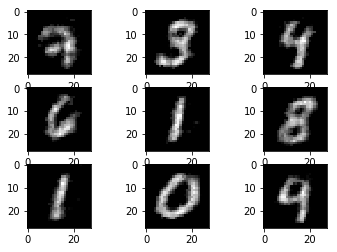

In [160]:
# zz = sample_Z(batch_size, g_dim)
# gg = sess.run(g_sample, feed_dict = {x_g: zz})
# gg = sess.run(discriminator(g_sample), feed_dict = {x_g: zz})
gg = sess.run(discriminator(x_d), feed_dict = {x_d: x_train})
gg_pic = np.array([np.reshape(m,(28,28)) for m in gg])
fig, ax = plt.subplots(nrows=3, ncols=3)
for i,row in enumerate(ax):
    for j,col in enumerate(row):
        ax[i][j].imshow(gg_pic[i*3+j], cmap='gray')
# print sess.run(discriminator(g_sample), feed_dict = {x_g: zz})
# print sess.run(encoder(x_d), feed_dict = {x_d: x_train})

In [161]:
for step in range(10001):
    batch_x = mnist.train.next_batch(batch_size)[0]
    sess.run(d_optimizer, feed_dict={x_d: batch_x, x_g: sample_Z(batch_size, g_dim)})
    sess.run(g_optimizer, feed_dict={x_g: sample_Z(batch_size, g_dim)})
    k_t = k_t + 0.001*(sess.run(balancer, feed_dict={x_d: batch_x, x_g: sample_Z(batch_size, g_dim)}))
    if step%1000==0:
        d_loss_train, g_loss_train, M_global_train = sess.run([d_loss, g_loss, M_global], feed_dict=
                            {x_d: batch_x, x_g: sample_Z(batch_size, g_dim)})
        print 'step:', step, ' d-loss:', d_loss_train, ' g-loss:', g_loss_train, 'k_t:', k_t,"M_global:", M_global_train

step: 0  d-loss: 0.0256045  g-loss: 0.000393668 k_t: 0.109397485834 M_global: 0.038013
step: 1000  d-loss: 0.0254603  g-loss: 0.000286403 k_t: 0.121646886037 M_global: 0.037904
step: 2000  d-loss: 0.0224544  g-loss: 0.00019818 k_t: 0.133435666339 M_global: 0.0334834
step: 3000  d-loss: 0.0229373  g-loss: 0.000140738 k_t: 0.144814824445 M_global: 0.0342653
step: 4000  d-loss: 0.0218203  g-loss: 0.000106455 k_t: 0.155805341321 M_global: 0.032624
step: 5000  d-loss: 0.0218022  g-loss: 9.2999e-05 k_t: 0.16643033203 M_global: 0.0326102
step: 6000  d-loss: 0.0204189  g-loss: 6.13733e-05 k_t: 0.176715824435 M_global: 0.0305669
step: 7000  d-loss: 0.0203125  g-loss: 3.59578e-05 k_t: 0.186694533558 M_global: 0.0304327
step: 8000  d-loss: 0.0187232  g-loss: 2.32812e-05 k_t: 0.196396783339 M_global: 0.0280615
step: 9000  d-loss: 0.0194302  g-loss: 1.76351e-05 k_t: 0.205832925871 M_global: 0.0291276
step: 10000  d-loss: 0.0184996  g-loss: 1.16868e-05 k_t: 0.215030769233 M_global: 0.0277378


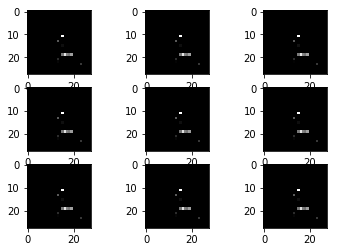

In [166]:
# gg = sess.run(g_sample, feed_dict = {x_g: zz})
gg = sess.run(discriminator(g_sample), feed_dict = {x_g: zz})
# gg = sess.run(discriminator(x_d), feed_dict = {x_d: x_train})
gg_pic = np.array([np.reshape(m,(28,28)) for m in gg])
fig, ax = plt.subplots(nrows=3, ncols=3)
for i,row in enumerate(ax):
    for j,col in enumerate(row):
        ax[i][j].imshow(gg_pic[i*3+j], cmap='gray')
# print sess.run(encoder(x_d), feed_dict = {x_d: x_train})

In [167]:
for step in range(10001):
    batch_x = mnist.train.next_batch(batch_size)[0]
    sess.run(d_optimizer, feed_dict={x_d: batch_x, x_g: sample_Z(batch_size, g_dim)})
    sess.run(g_optimizer, feed_dict={x_g: sample_Z(batch_size, g_dim)})
    k_t = k_t + 0.001*(sess.run(balancer, feed_dict={x_d: batch_x, x_g: sample_Z(batch_size, g_dim)}))
    if step%1000==0:
        d_loss_train, g_loss_train, M_global_train = sess.run([d_loss, g_loss, M_global], feed_dict=
                            {x_d: batch_x, x_g: sample_Z(batch_size, g_dim)})
        print 'step:', step, ' d-loss:', d_loss_train, ' g-loss:', g_loss_train, 'k_t:', k_t,"M_global:", M_global_train

step: 0  d-loss: 0.0186068  g-loss: 1.17107e-05 k_t: 0.215040061087 M_global: 0.0278985
step: 1000  d-loss: 0.017647  g-loss: 1.01459e-05 k_t: 0.224016705996 M_global: 0.0264603
step: 2000  d-loss: 0.0178731  g-loss: 9.41275e-06 k_t: 0.232794860967 M_global: 0.0268002
step: 3000  d-loss: 0.0175915  g-loss: 1.02035e-05 k_t: 0.241392334107 M_global: 0.026377
step: 4000  d-loss: 0.0158813  g-loss: 1.2259e-05 k_t: 0.249815984611 M_global: 0.0238097
step: 5000  d-loss: 0.0166391  g-loss: 1.66838e-05 k_t: 0.258081606587 M_global: 0.0249419
step: 6000  d-loss: 0.0158728  g-loss: 1.74792e-05 k_t: 0.266193517146 M_global: 0.0237918
step: 7000  d-loss: 0.0160493  g-loss: 2.10427e-05 k_t: 0.274171646341 M_global: 0.0240529
step: 8000  d-loss: 0.0155107  g-loss: 2.12958e-05 k_t: 0.282024630587 M_global: 0.0232448
step: 9000  d-loss: 0.0150629  g-loss: 2.29677e-05 k_t: 0.289759631091 M_global: 0.0225714
step: 10000  d-loss: 0.0154016  g-loss: 2.40316e-05 k_t: 0.29738505266 M_global: 0.0230784


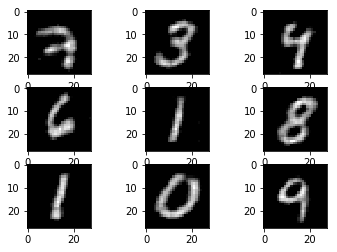

In [170]:
# gg = sess.run(g_sample, feed_dict = {x_g: zz})
# gg = sess.run(discriminator(g_sample), feed_dict = {x_g: zz})
gg = sess.run(discriminator(x_d), feed_dict = {x_d: x_train})
gg_pic = np.array([np.reshape(m,(28,28)) for m in gg])
fig, ax = plt.subplots(nrows=3, ncols=3)
for i,row in enumerate(ax):
    for j,col in enumerate(row):
        ax[i][j].imshow(gg_pic[i*3+j], cmap='gray')
# print sess.run(encoder(x_d), feed_dict = {x_d: x_train})

In [235]:
z1 = sess.run(encoder(x_d), feed_dict = {x_d: [x_train[1]]})
z2 = sess.run(encoder(x_d), feed_dict = {x_d: [x_train[6]]})
z3 = sess.run(encoder(x_d), feed_dict = {x_d: [x_train[2]]})
z4 = sess.run(encoder(x_d), feed_dict = {x_d: [x_train[5]]})

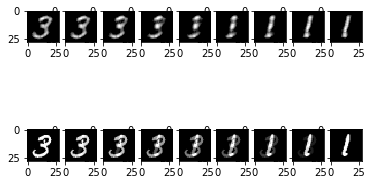

In [233]:
# fig, ax = plt.subplots(ncols=9)
# for i,row in enumerate(ax):
# #     for j,col in enumerate(row):
#     z_tmp = z1+(z2-z1)*i/8
#     x_tmp = sess.run(decoder(x_g), feed_dict = {x_g: z_tmp})
#     ax[i].imshow(x_tmp, cmap='gray')

fig, ax = plt.subplots(nrows=2, ncols=9)
# for i,row in enumerate(ax):
for j,col in enumerate(ax[0]):
    z_tmp = z1+(z2-z1)*j/8
    x_tmp = sess.run(decoder(x_g), feed_dict = {x_g: z_tmp})
#         x_tmp = sess.run(generator(x_g), feed_dict = {x_g: z_tmp})
    x_tmp = np.reshape(x_tmp,(28,28))
    ax[0][j].imshow(x_tmp, cmap='gray')
#         print j , z_tmp ,x_tmp
for j,col in enumerate(ax[1]):
    x_tmp = x_train[1]+(x_train[6]-x_train[1])*j/8
#     x_tmp = sess.run(decoder(x_g), feed_dict = {x_g: z_tmp})
#         x_tmp = sess.run(generator(x_g), feed_dict = {x_g: z_tmp})
    x_tmp = np.reshape(x_tmp,(28,28))
    ax[1][j].imshow(x_tmp, cmap='gray')

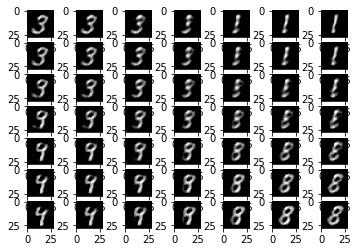

In [241]:
fig, ax = plt.subplots(nrows=7, ncols=7)
for i,row in enumerate(ax):
    for j,col in enumerate(row):
        z_tmp = (1-(i/6.))*(1-(j/6.))*z1+(i/6.)*(1-(j/6.))*z3+(1-(i/6.))*(j/6.)*z2+(i/6.)*(j/6.)*z4
        x_tmp = sess.run(decoder(x_g), feed_dict = {x_g: z_tmp})
        ax[i][j].imshow(x_tmp.reshape(28,28), cmap='gray')


In [ ]:
for step in range(50001):
    batch_x = mnist.train.next_batch(batch_size)[0]
    sess.run(d_optimizer, feed_dict={x_d: batch_x, x_g: sample_Z(batch_size, g_dim)})
    sess.run(g_optimizer, feed_dict={x_g: sample_Z(batch_size, g_dim)})
    k_t = k_t + 0.001*(sess.run(balancer, feed_dict={x_d: batch_x, x_g: sample_Z(batch_size, g_dim)}))
    if step%1000==0:
        d_loss_train, g_loss_train, M_global_train = sess.run([d_loss, g_loss, M_global], feed_dict=
                            {x_d: batch_x, x_g: sample_Z(batch_size, g_dim)})
        print 'step:', step, ' d-loss:', d_loss_train, ' g-loss:', g_loss_train, 'k_t:', k_t,"M_global:", M_global_train

In [ ]:
gg = sess.run(g_sample, feed_dict = {x_g: zz})
gg_pic = np.array([np.reshape(m,(28,28)) for m in gg])
fig, ax = plt.subplots(nrows=3, ncols=3)
for i,row in enumerate(ax):
    for j,col in enumerate(row):
        ax[i][j].imshow(gg_pic[i*3+j], cmap='gray')